In [1]:
import numpy as np
import math
import scipy
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from scipy.stats import qmc
from sklearn.gaussian_process.kernels import ConstantKernel
import fusionrate
from fusionrate import Reaction

In [2]:
from dataclasses import dataclass

In [20]:
@dataclass
class TrainedData:
    
    #these will be running "totals" of all training data 
    x_train: list #inputs (alpha_n, alpha_T, T0)
    y_train: list #outputs (c, B)
        
td = TrainedData(list(),list())

def generate_profile(rho, x0, alpha_x):
    """This function generates radial based parabolic profiles 
    for densities / temperatures , 0<rho<1
    
    args
    ----------
    - rho (array-like): radial position
    - n0 (float): denisity / temperature at rho = 0 
    - alpha_x (float): exponential value predicted between 1.00 - 3.00 
    
    returns
    ----------
    - profile (array-like): an array of radial based profiles (temp or density)
    
    """
    profile = x0 * ((1 - (rho**2))**alpha_x)
    
    return profile 

def volume_averaged_density(densities, volumes):
    """This function finds the volume averaged density 
    
    Parms:
        - densisties (array-like): an array of densities of each partition
        - volumes (array-like): an array of volumes of each parition
        
    Returns:
        - vol_avg_density (float): density averaged over the whole volume
    """
    vol_avg_density = (np.sum(np.multiply(densities,volumes)))/(np.sum(volumes))
    
    return vol_avg_density

def volume_averaged_temperature(densities, volumes, temperatures):
    """This function finds the volume averaged temperature 
    
    Params: 
        - densities(array-like): an array of densities of each partition
        - volumes(array-like): an array of volumes of each parition
        - temperature(array-like): an array of temperatures of each partition 

    Returns: 
        - vol_avg_temperature (float): temperature averaged over the whole volume 
    
    """
    vol_avg_temperature = (np.sum(np.multiply(temperatures,(np.multiply(densities,volumes))))/(np.sum(np.multiply(densities,volumes))))
    type(vol_avg_temperature)
    
    return vol_avg_temperature

def generate_volumes(rho, a, R):
    '''This function creates an array of volume elements of equal temperature and density
    
    args
    ------
    rho (array-like): array of radii 
    a (float): minor radius of torus
    R (float): major radius of torus 
    
    return
    -------
    volumes (array-like): array of volume elements 
    
    '''
    drho = 1/len(rho) #the change in rho is the amount of lengths (1/100th in this case)
    
    #initialzing
    total_area = 0 
    
    volumes = []
    
    for i in rho: #indexing elements of array rho
        ring_area = (a**2) * i * drho * 2*math.pi 
        ring_volume = ring_area *2*math.pi * R
        volumes.append(ring_volume)
        
    return volumes

def initialize_training_data():
    ''' Initializes variable x_train, calls generated halton sequence and adds to x_train
    '''
    n = 100 #number of training points 
    ranges = [(1,5), (1,5), (1,100)] #ranges for alpha_n, alpha_T, and T0
    sequence = generate_halton_sequence(n, ranges) #call generate_halton_sequence for number of training points and ranges 
    
    #ensure 'sequence' is a list
    sequence = sequence.tolist()
    td.x_train.extend(sequence) #adds sequence to x_train list 
    
    #generate corresponding y_train from x_train (generate_lowfidelityFR )
    
    for x in td.x_train:
        x = alpha_n, alpha_T, T0 
        y = generate_lowfidelityFR(n0, alpha_n, T_0, alpha_T, a, R)
        td.y_train.append(y) #modify y_train to include new training points


#Fusion Rate Models : 
def compute_highfidelityFR(n0, alpha_n, T0, alpha_T, a, R):
    '''This function computes the high-fidelity fusion rate
    
    args
    ------
    - n0: initial density, estimate around 10**20 (float) 
    - alpha_n: exponential (flot)
    - T0: initial temperature, estimate around 10 Kev (float)
    - alpha_T: exponential (float)
    - a: torus minor radius (float)
    - R: torus major radius (float)
    
    returns
    --------
    - highfidelityFR: high-fidelity fusion rate (float)
    
    '''
    rho = np.linspace(0,1,num=100) 

    densities = generate_profile(rho,n0,alpha_n)
    
    temperatures = generate_profile(rho,T0,alpha_T)
        
    volumes = generate_volumes(rho,a,R)
    
    dt = Reaction('D+T')
    rate_coeff = dt.rate_coefficient(temperatures, scheme = 'analytic')

    sectionalHFFR = (np.multiply(rate_coeff,np.multiply(densities,densities))) 
    
    highfidelityFR=sum(np.multiply(sectionalHFFR,volumes))
    
    return highfidelityFR

def compute_highfidelityFR_deriv(n0, alpha_n, T0, alpha_T, a, R):
    '''This function computes the derivative of the high-fidelity fusion rate with respect to temperature
    
    args
    ------
    -n0: initial density, estimate around 10**20 (float) 
    - alpha_n: exponential (float)
    - T0: initial temperature, estimate around 10 Kev (float)
    - alpha_T: exponential (float)
    - a: torus minor radius (float)
    - R: torus major radius (float)
    
    returns
    --------
    - highfidelityFR_deriv: derivative of high fidelity fusion rate (float)

    '''
    rho = np.linspace(0,1,num=100)

    densities = generate_profile(rho,n0,alpha_n)
    
    temperatures = generate_profile(rho,T0,alpha_T)
    
    volumes = generate_volumes(rho,a,R)
    
    dt = Reaction("D+T")
    rate_coeff_deriv = dt.rate_coefficient(temperatures, scheme ='analytic',derivatives=True)
    
    sectionalHFFR_deriv = (np.multiply(rate_coeff_deriv,np.multiply(densities,densities)))
    
    highfidelityFR_deriv=sum(np.multiply(sectionalHFFR_deriv,volumes))
    
    return highfidelityFR_deriv

def compute_lowfidelityFR(n0, alpha_n, T0, alpha_T, a, R, c, B):
    """This function computes the low-fidelity fusion rate
    
    args
    ------
    -n0: initial density, estimate around 10**20 (float) 
    - alpha_n: exponential (float)
    - T0: initial temperature, estimate around 10 Kev (float)
    - alpha_T: exponential (float)
    - a: torus minor radius (float)
    - R: torus major radius (float)
    - c: (float)
    - B: (float)
    
    returns
    --------
    - lowfidelityFR: low-fidelity fusion rate (float)
    
    """
    rho = np.linspace(0,1,num=100)
    
    densities = generate_profile(rho,n0,alpha_n)
    temperatures = generate_profile(rho,T0,alpha_T)
    volumes = generate_volumes(rho,a,R)
    
    total_volume = sum(volumes)
    
    vol_avg_density = volume_averaged_density(densities, volumes)
    vol_avg_temperature = volume_averaged_temperature(densities, volumes, temperatures)
    
    
    lowfidelityFR = total_volume * C_SCALE * c * vol_avg_density**2 *vol_avg_temperature**B
    
    return lowfidelityFR
    
def compute_lowfidelityFR_deriv(n0, alpha_n, T0, alpha_T, a, R, c, B):
    """This function computes the derivative of the high-fidelity fusion rate with respect to temperature
    
     args
    ------
    -n0: initial density, estimate around 10**20 (float) 
    - alpha_n: exponential (int)
    - T0: initial temperature, estimate around 10 Kev (float)
    - alpha_T: exponential (int)
    - a: torus minor radius (float)
    - R: torus major radius (float)
    - c: (float)
    - B: (float)
    
    returns
    ---------
    -lowfidelityFR_deriv: derivative of low-fidelity fusion rate (float)
    
    """
    rho = np.linspace(0,1,num=100)
    
    densities = generate_profile(rho,n0,alpha_n)
    temperatures = generate_profile(rho,T0,alpha_T)
    volumes = generate_volumes(rho,a,R)
    
    total_volume = sum(volumes)
    
    vol_avg_density = volume_averaged_density(densities, volumes)
    vol_avg_temperature = volume_averaged_temperature(densities, volumes, temperatures)

    lowfidelityFR_deriv = total_volume * C_SCALE * c * vol_avg_density**2 * B * vol_avg_temperature**(B-1)
    
    return lowfidelityFR_deriv
    
def generate_lowfidelityFR(n0, alpha_n, T0, alpha_T, a, R):
    '''This function generates parameters necessary for computation of the low-fidelity FR model
   
   args
    ------
    -n0: initial density, estimate around 10**20 (float) 
    - alpha_n: exponential (float)
    - T0: initial temperature, estimate around 10 Kev (float)
    - alpha_T: exponential (float)
    - a: torus minor radius (float)
    - R: torus major radius (float)
    
    returns
    --------
    - c: compute best guess from formula (float)
    - B: best guess around 2 (float)
    '''
    rho = np.linspace(0,1,num=100)
    
    highfidelityFR = compute_highfidelityFR(n0, alpha_n, T0, alpha_T, a, R)
    highfidelityFR_deriv = compute_highfidelityFR_deriv(n0, alpha_n, T0, alpha_T, a, R)
    
    densities = generate_profile(rho,n0,alpha_n)
    temperatures = generate_profile(rho,T0,alpha_T)
    volumes = generate_volumes(rho,a,R)
    
    total_volume = sum(volumes)
    
    vol_avg_density = volume_averaged_density(densities, volumes)
    vol_avg_temperature = volume_averaged_temperature(densities, volumes, temperatures)
    
    def f1(c,B):
        return total_volume * c * vol_avg_density**2 *vol_avg_temperature**B - highfidelityFR / C_SCALE
    
    def f2(c,B):
        return total_volume * c * vol_avg_density**2 * B * vol_avg_temperature**(B-1) - highfidelityFR_deriv / C_SCALE
    
    def f(c,B):
        return f1(c,B), f2(c,B)
    
    def wrapper_of_f_for_fsolve(x):
        return np.array(f(*x))
    
    c_sol = scipy.optimize.fsolve(wrapper_of_f_for_fsolve, [1,2], xtol=1e-2)
    fofcsol = f(*c_sol)
    
    return c_sol #c_sol will need to be indexed as c = c_sol[0], B = c_sol[1], built to return c and B

def x_test_from_generic_inputs(n0, alpha_n, T_0, alpha_T, a, R):
    ''' converts physics inputs into a x_test point 
    Args
    --------
    -n0: initial density, estimate around 10**20 (float) 
    - alpha_n: exponential (int)
    - T0: initial temperature, estimate around 10 Kev (float)
    - alpha_T: exponential (int)
    - a: torus minor radius (float)
    - R: torus major radius (float)
    - c: (float)
    - B: (float)
    
    
    Returns
    ---------
    x_test (array-like): 1d np.array of alpha_n, alpha_T, T0
    
    '''
    x_test = np.array()
    x_test = [no, alpha_n, T0] #not sure if this is correct or correct order 
    
def generate_halton_sequence(n, ranges):
    """
    This function generates the training points for data over interesting ranges
    
    Arguments:
    - n: The number of points to generate.
    - ranges: A list of tuples specifying the range for each dimension.
    
    Returns:
    A list of tuples representing the generated points in the Halton sequence.
    """
    num_dimensions = len(ranges)
    low = np.array([min_value for min_value, _ in ranges])
    high = np.array([max_value for _, max_value in ranges])
    halton = qmc.Halton(num_dimensions)
    scaled_points = halton.random(n)
    scaled_points = low + scaled_points * (high - low)
    sequence = [tuple(point) for point in scaled_points]
    
    return sequence

def add_training_points(new_x_train, new_y_train):
    # may need some conversions 
    
    td.x_train.append(new_x_train)
    
    td.y_train.append(new_y_train)
    
def evaluate_values(x_train, y_train, x_test):
    '''
    This function returns the prediction for c and B given a 2D array test point 
    
    args
    ------
    X_train (array-like) : training data - "randomly" generated on interesting bounds
    y_train (array- like) : produced in generate low fidelity function returning associated c and B values 
    X_test (array-like) : point for uncertainty to be evauluated at (2d array)
    
    returns
    --------
    yc_std (float): The prediction of c at X_test
    yB_std (float): The prediction deviation of B at X_test
    
    '''

    yc,yB = np.array(y_train).T
    
    #defining the kernel for c then B
    kernelc = ConstantKernel(constant_value=1.0,constant_value_bounds=(1e-2,1e2)) * RBF(length_scale=1, length_scale_bounds=(1e-2,100))   
    kernelB = ConstantKernel(constant_value=1.0,constant_value_bounds=(.1,10)) * RBF(length_scale=0.5, length_scale_bounds=(0.1,100))   
    
    #create a GPR model
    gprc = GaussianProcessRegressor(kernel=kernelc, n_restarts_optimizer=9)
    gprB = GaussianProcessRegressor(kernel=kernelB, n_restarts_optimizer=9)
    
    #fit model to data
    gprc.fit(X, np.log(yc))
    gprB.fit(X,yB)
    
    #generate points in inputspace to predict 
    x_pred = np.linspace(0,5,100)

    #predict function values for input points & standard deviation 
    yc_pred= gprc.predict(X_test, return_std = False)[1][0]
    yB_pred = gprB.predict(X_test, return_std = False)[1][0]
    
    #print("The standard deviation of c at", point, "is", yc_std*10e-16, "(log units)")
    #print("The standard deviation of B at", point, "is", yB_std)
    
    return yc_pred.item(), yB_pred.item()

def evaluate_uncertainty(x_train, y_train, x_test):
    '''
    This function returns the uncertainty/ error/ standard dev for c and B given a 2D array test point 
    
    args
    ------
    X_train (array-like) : training data - "randomly" generated on interesting bounds
    y_train (array- like) : produced in generate low fidelity function returning associated c and B values 
    X_test (array-like) : point for uncertainty to be evauluated at (2d array)
    
    returns
    --------
    yc_std (float): The standard deviation of c at X_test
    yB_std (float): The standard deviation of B at X_test
    
    '''

    yc,yB = np.array(y_train).T
    
    #defining the kernel for c then B
    kernelc = ConstantKernel(constant_value=1.0,constant_value_bounds=(1e-2,1e2)) * RBF(length_scale=1, length_scale_bounds=(1e-2,100))   
    kernelB = ConstantKernel(constant_value=1.0,constant_value_bounds=(.1,10)) * RBF(length_scale=0.5, length_scale_bounds=(0.1,100))   
    
    #create a GPR model
    gprc = GaussianProcessRegressor(kernel=kernelc, n_restarts_optimizer=9)
    gprB = GaussianProcessRegressor(kernel=kernelB, n_restarts_optimizer=9)
    
    #fit model to data
    gprc.fit(X, np.log(yc))
    gprB.fit(X,yB)
    
    #generate points in inputspace to predict 
    x_pred = np.linspace(0,5,100)

    #predict function values for input points & standard deviation 
    yc_std = gprc.predict(X_test, return_std = True)[1][0]
    yB_std = gprB.predict(X_test, return_std = True)[1][0]
    
    #print("The standard deviation of c at", point, "is", yc_std*10e-16, "(log units)")
    #print("The standard deviation of B at", point, "is", yB_std)
    
    return yc_std.item(), yB_std.item()
    
def test_uncertainty(std_devs, max_uncertainty):
    '''The purpose of this function is to test if the uncertainty is within bounds of the max uncertainty
    args
    -----
    std (tuple): tuple of errors for c and B
    max_uncertainty): tuple of associated allowed errors 
    
    returns
    ---------
    bool
    
    '''
    #max uncert may need to be a tuple - can't set one specific uncert for both ex 20% of accepted value
    return std[0] <= max_uncertainty[0] and std[1] <= max_uncertainty[1]

def get_a_point(n0, alpha_n, T_0, alpha_T, a, R, uncertainty):
    '''This function takes in a point and alloted uncertainty and returns the fusion rate 
    
    Args
    ----
     -n0: initial density, estimate around 10**20 (float) 
    - alpha_n: exponential (float)
    - T0: initial temperature, estimate around 10 Kev (float)
    - alpha_T: exponential (float)
    - a: torus minor radius (float)
    - R: torus major radius (float)
    - uncertainty (float) 
    
    Returns
    --------
    - Total fusion rate
    
    '''
    x_test = x_test_from_generic_inputs(n0, alpha_n, T_0, alpha_T, a, R) # create test points 
    c, B = evaluate_values(x_train, y_train, x_test) # use the GPR to find corresponding prediction values for x_test based on trained data 
    yc_std, yB_std = evaluate_uncertainty(x_train, y_train, x_test) #evaluate the uncertainty of those predicted values 
    
    std = (yc_std,yB_std) 
    is_acceptable = test_uncertainty(std, uncertainty)
                           
    if is_acceptable:
        #use c and B to evaluate lfm - the error is minimal enough to accept LFM 
        compute_lowfidelityFR(n0, alpha_n, T0, alpha_T, a, R, c, B)
                           
    else:
        #The error is too large to accept lfm - 
        c, B = generate_lowfidelityFR(n0, alpha_n, T0, alpha_T, a, R) #use the HFM to calculate c,B 
        new_y_train = np.array([c,B]) 
        add_training_points(new_x_train, new_y_train) #add those to new training data
        compute_lowfidelityFR(n0, alpha_n, T0, alpha_T, a, R, c, B) #find fusion rate based on c & B 
    return c, B
                           
                           

In [21]:
print(c)

NameError: name 'c' is not defined

In [17]:
n_grid = 200 #sets number of points in each grid to 200

alpha_n_test = np.linspace(1,5, num =n_grid) #200 points between 1 and 5
alpha_T_test = np.linspace(1,5,num =n_grid) #200 points between 1 and 5 
T0_test=np.geomspace(1,100,num =n_grid) #logarithmically spaced values 

alpha_T_grid, T0_grid = np.meshgrid(alpha_T_test, T0_test) #creates a grid of points from alpha_T_test and T0 test
alpha_n_grid = np.ones_like(alpha_T_grid)*2.0 #array filled with 2s


AttributeError: 'TrainedData' object has no attribute 'c'

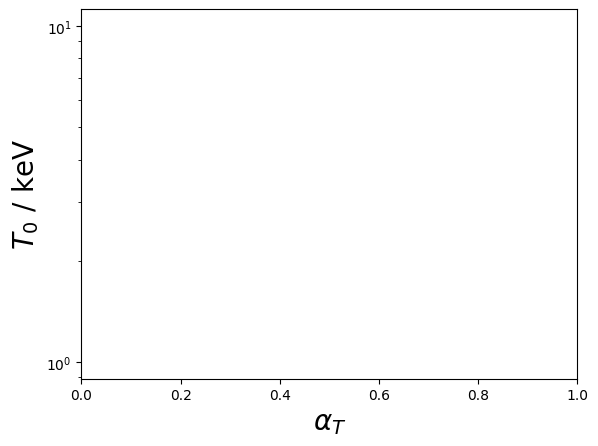

In [23]:
fig1, ax = plt.subplots()
ax.set_yscale('log')
plt.xlabel(r"$\alpha_T$", size = 20)
plt.ylabel(r"$T_0$ / keV", size = 20)
CS = ax.contourf(alpha_T_grid, T0_grid, td.c)
#ax.clabel(CS, inline= True, fontsize = 10)
plt.axis([1,5,1,100])
ax.set_title('Predicted Value ' + r'$\log(c * 10^{16} \; \mathrm{m}^{-3}\mathrm{s})$', size = 20)

ax.tick_params(axis='both', which='major', labelsize=15)

cbar = fig1.colorbar(CS)
cbar.ax.set_ylabel('c Prediction', size = 20)